In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gym

from keras.models import Model
from keras.layers import Input, Dense, merge
import keras.backend as K

from tqdm import tnrange, tqdm_notebook

Using TensorFlow backend.


In [2]:
def main(env, agent, steps=100000, plot=True):
    try:
        total_rewards = []
        total_reward = 0
        reset = True
        for step in tnrange(steps):
            if reset:
                obs = env.reset()
                agent.reset()
                
                total_rewards.append(total_reward)
                total_reward = 0
            
            action = agent.action(obs)
            new_obs, reward, reset, info = env.step(action)
            agent.observe(obs, action, reward, reset, new_obs)
            
            obs = new_obs
            total_reward += reward
        plt.plot(total_rewards)
    finally:
        env.close()

In [3]:
class RandomAgent(object):
    def __init__(self, env): self.env = env
    def action(self, obs): return self.env.action_space.sample()
    def reset(self): pass
    def observe(self, *args): pass

In [4]:
class ActorCriticAgent(object):
    
    def __init__(self, env):
        model = discrete_model(env)
        self.policy = DiscretePolicy(model)
        
    
    def action(self, obs):
        return self.policy.action(obs)
        
    def observe(self, obs, action, reward, done, new_obs):
        pass
    
    def reset(self):
        pass

In [5]:
class DiscretePolicy(object):
    
    def __init__(self, model, optimizer='rmsprop'):
        obs = model.input
        proba = model.output
        action = Input(name='action', shape=(1,), dtype='int32')
        action_proba = merge([action, proba], mode=merge_action_proba, output_shape=(1,))
        fit_model = Model(input=[obs, action], output=action_proba)
        fit_model.compile(optimizer=optimizer, loss=policy_loss)
        
        self.fit_model = fit_model
        self.predict_model = model
        
    def action(self, obs):
        obs = np.asarray([obs])
        proba = self.predict_model.predict_on_batch(obs)[0]
        action = np.random.choice(len(proba), p=proba)
        return action
        
def merge_action_proba(args):
    action, proba = args
    proba_shape = tf.shape(proba)
    batchsize, actions = proba_shape[0], proba_shape[1]
    flat_proba = tf.reshape(proba, [-1])
    flat_action = tf.reshape(action, [-1])
    offset = actions * tf.range(batchsize)
    indices = flat_action + offset
    flat_action_proba = tf.gather(flat_proba, indices)
    action_proba = tf.expand_dims(flat_action_proba, -1)
    return action_proba

def policy_loss(advantage, action_proba):
    advantage = tf.reshape(advantage, [-1])
    action_proba = tf.reshape(action_proba, [-1])
    return advantage * tf.log(action_proba)

In [6]:
def discrete_model(env):
    obs_shape = env.observation_space.shape
    actions = env.action_space.n
    if len(obs_shape) > 1:
        raise NotImplementedError()
        
    obs = Input(name='observation', shape=obs_shape)
    hidden = Dense(40, activation='tanh')(obs)
    hidden = Dense(40, activation='tanh')(hidden)
    proba = Dense(actions, activation='softmax')(hidden)
    model = Model(input=obs, output=proba)
    return model

[2017-01-08 11:41:29,226] Making new env: CartPole-v1


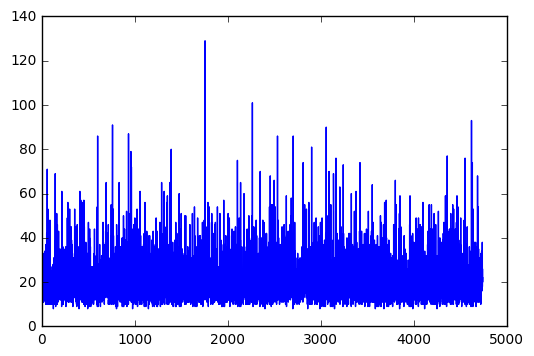

In [7]:
env = gym.make('CartPole-v1')
agent = ActorCriticAgent(env)
main(env, agent)